#  Run BADASS on Alpha Amylase data

In [8]:
# %run setup_environment.py
import badass.models.seq2fitness_models as models
import badass.training.seq2fitness_traintools as traintools
import badass.training.seq2fitness_train as train
import badass.mld.seq2fitness_protein_optimizer as protein_optimizer
import pickle
import time
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

## Using ESM2 model for num_mutations=5

In [2]:
ref_seq_amylase = """LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAIS
NEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANY
MDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAI
TAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD""".replace('\n','')

In [3]:
esm_score_weights = {'mutant': 1.0,
                     'reference': 0.0
    } # Use mutant score only

model_params = {
    'ref_seq': ref_seq_amylase, # in the model checkpoint params
    'esm_modelname': 'esm2_t33_650M_UR50D',
    'esm_score_weights': esm_score_weights
}

optimizer_params = {
    'seqs_per_iter': 500, # typically 1000
    'num_iter': 200, # typically 250 or more. But 100 is enough for a test
    'T': 1.5, # 10 when not normalizing scores
    'score_threshold': 35,
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9, # for slower simple cooling
    'num_mutations': 5,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

# Initialize optimizer
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_params=model_params, 
                                               esm_only=True,
                                               score_matrix=None, # Initialize in optimizer
                                               simple_simulated_annealing=False, 
                                               cool_then_heat=False)
print(f"phase transition threshold is {optimizer.score_threshold}")



Our main device will be cuda:0
The reference sequence is LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD.
We'll use 2 GPUs through DataParallel.
Our main device is still cuda:0
The reference sequence has score 0.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 8056 single mutants.
Finished sequence 0 of 8056.
Finished sequence 500 of 8056.
Finished sequence 1000 of 8056.
Finished sequence 1500 of 8056.
Finished sequence 2000 of 8056.
Finished sequence 2500 of 8056.
Finished sequence 3000 of 8056.
Finished sequence 3500 of 8056.
F

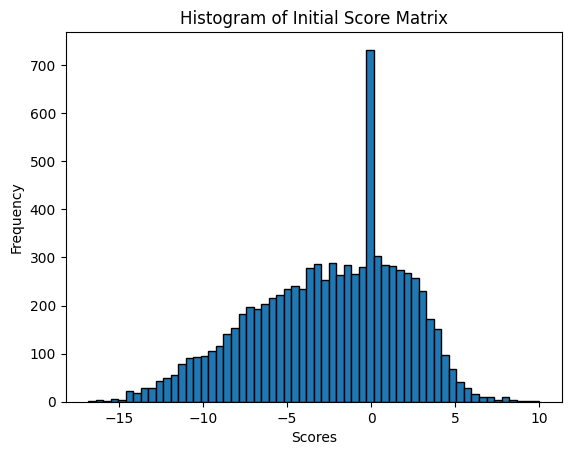

In [5]:
# If score_matrix is set to None, it is initialized with model fitness scores of single variants.
# The score matrix can be modified for subsequent sampling

# Assess score matrix
score_matrix = optimizer.initial_score_matrix # Initial matrix before optimization
#score_matrix = optimizer.score_matrix # Dynamic matrix updated in each iteration
flattened_scores = score_matrix.flatten()

# Plot the histogram with 60 bins
plt.hist(flattened_scores, bins=60, edgecolor='black')
plt.title('Histogram of Initial Score Matrix')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Run the optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()

Starting iter 0: processing 500 sequences, using T = 1.5.
Joint probability has 5.73e+03 effective entries: 331 sites, 18.4 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 500 sequences. Finished iter 0 with mean ml score of -1.88, and std. dev. 9.07.
Starting iter 1: processing 500 sequences, using T = 1.4.
Joint probability has 4.75e+03 effective entries: 307 sites, 17.8 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1000 sequences. Finished iter 1 with mean ml score of -0.0932, and std. dev. 8.69.
Starting iter 2: processing 500 sequences, using T = 1.2.
Joint probability has 3.94e+03 effective entries: 278 sites, 17.6 amino acids.
>> 500 out of 500 sequences this iteration are new and will be scored.
We have explored 1500 sequences. Finished iter 2 with mean ml score of 2.52, and std. dev. 8.1.
Starting iter 3: processing 500 sequences, using T = 1.1.
Joint probability has 3.3

/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py

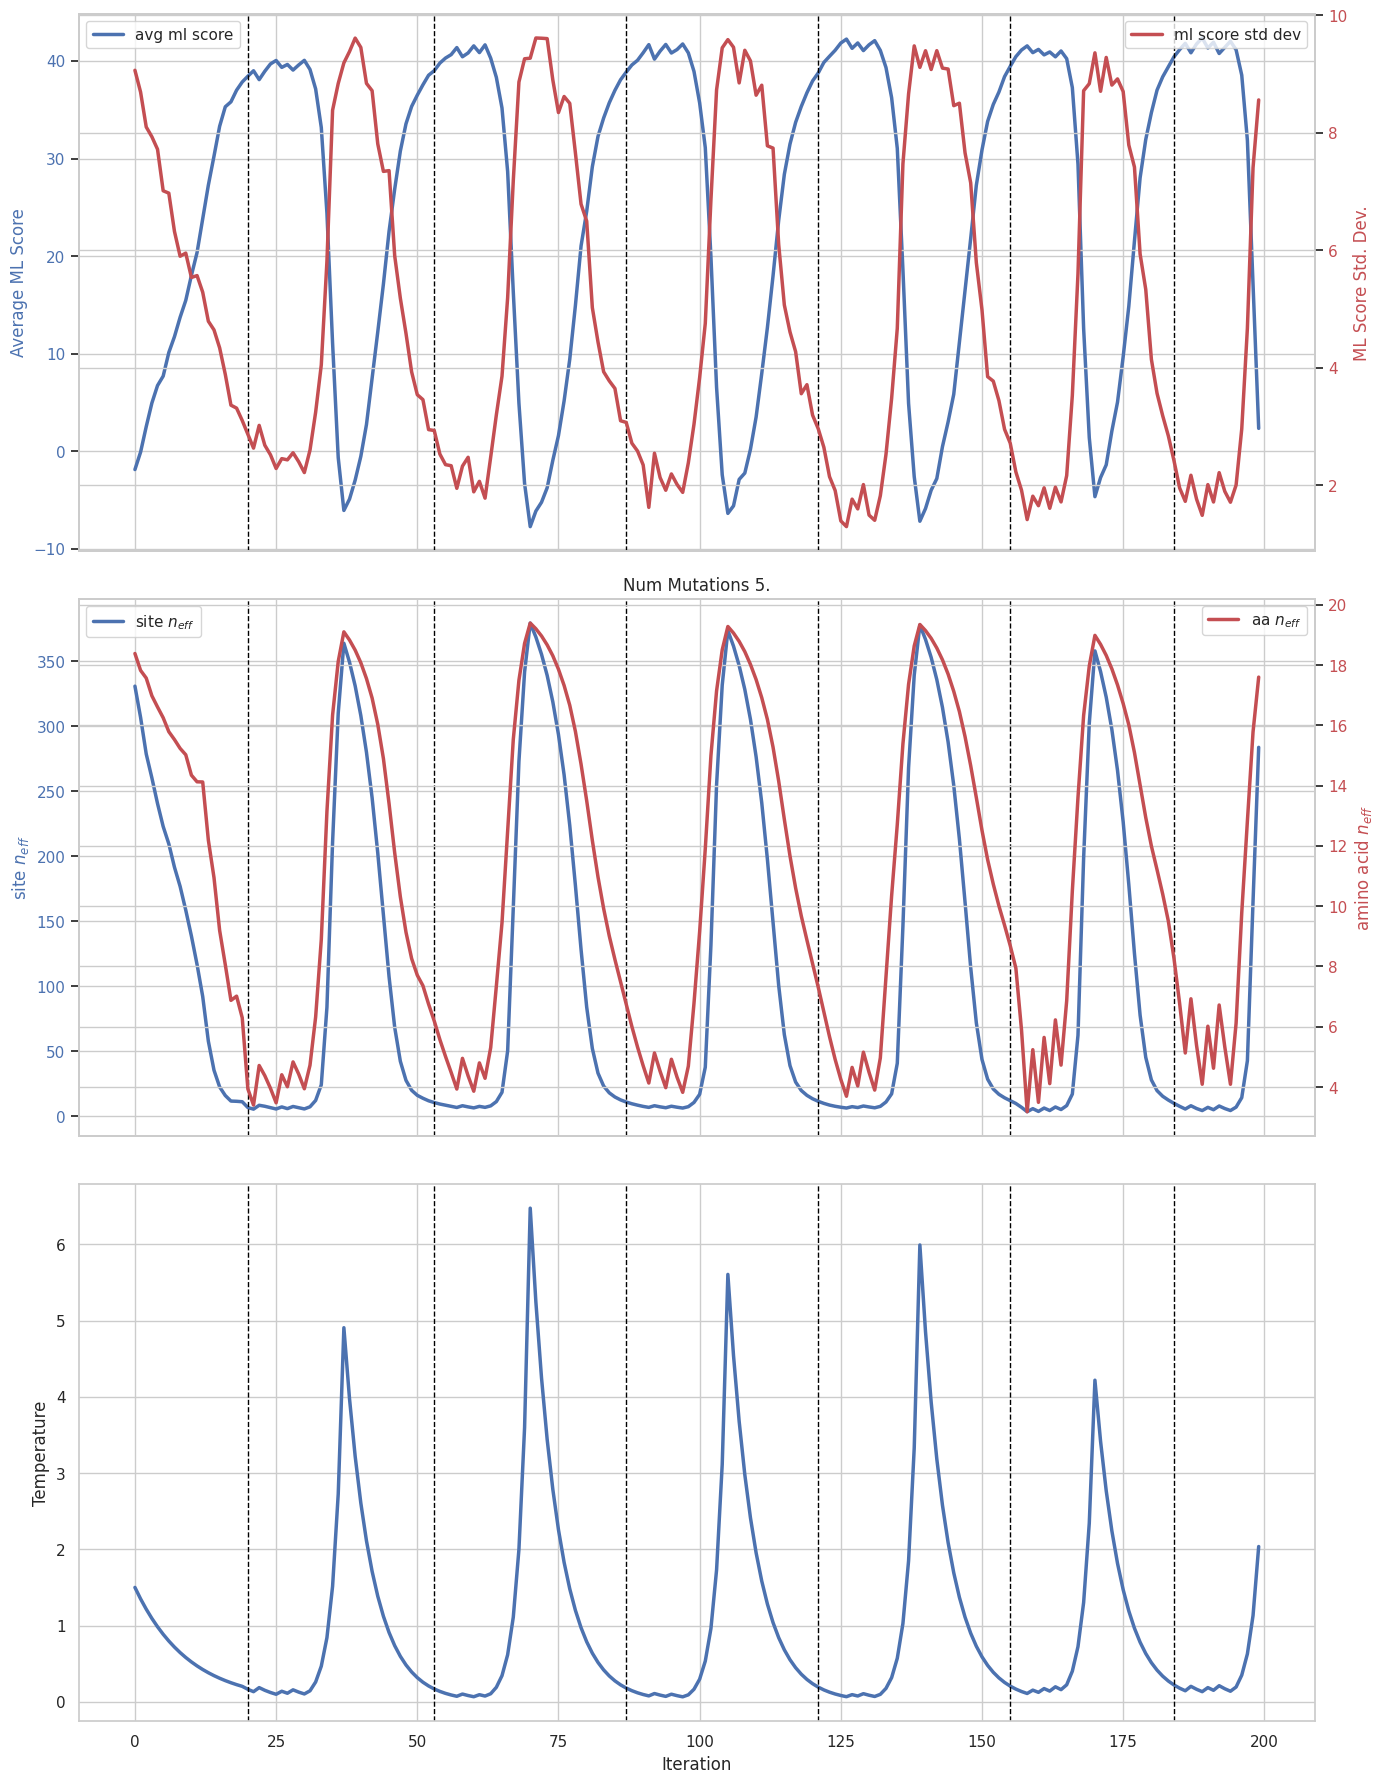

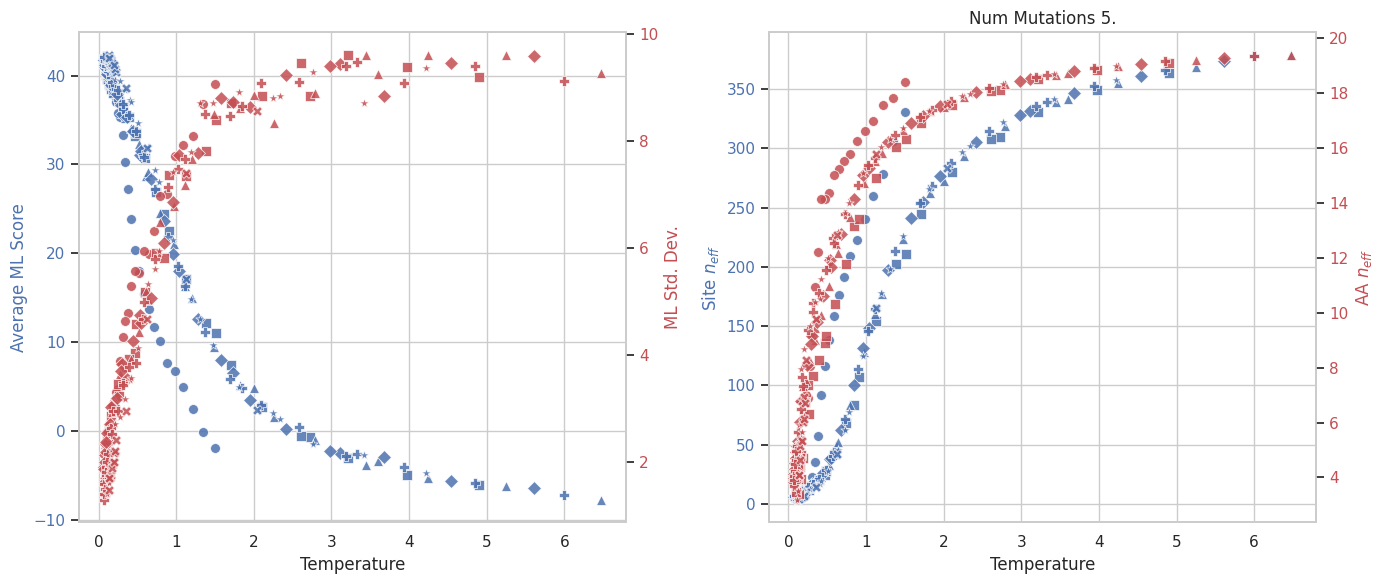

19
19


/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


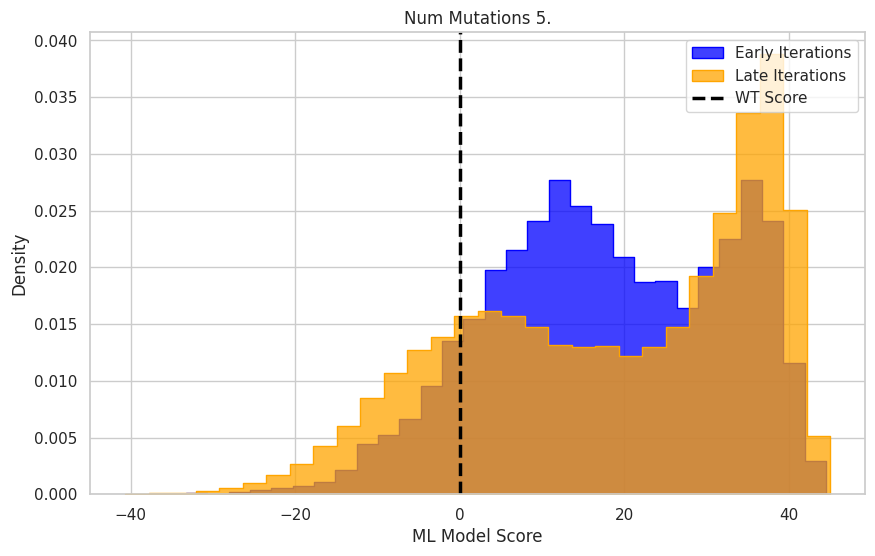

In [7]:
# View optimization history
optimizer.plot_scores()

In [9]:
# Save optimizer results
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
seed = optimizer_params['seed']
fn = f"protein_optimizer_results_num_mutations_{n_mut}_nsteps_{n_steps}_seed_{seed}_n_seqs_to_keep_{len(df)}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=None)

# View runtime
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
torch.cuda.empty_cache()
gc.collect()

Elapsed time: 636.37 seconds


3240

There were 67600 unique sequences found.
Best Sequence:
H24E-T198L-S201G-E331K-N364V
Best Score: 44.9766
Percentiles:
  25th Percentile: 4.5535
  50th Percentile: 20.9580
  75th Percentile: 34.4844
  90th Percentile: 38.6797
  99th Percentile: 42.4414


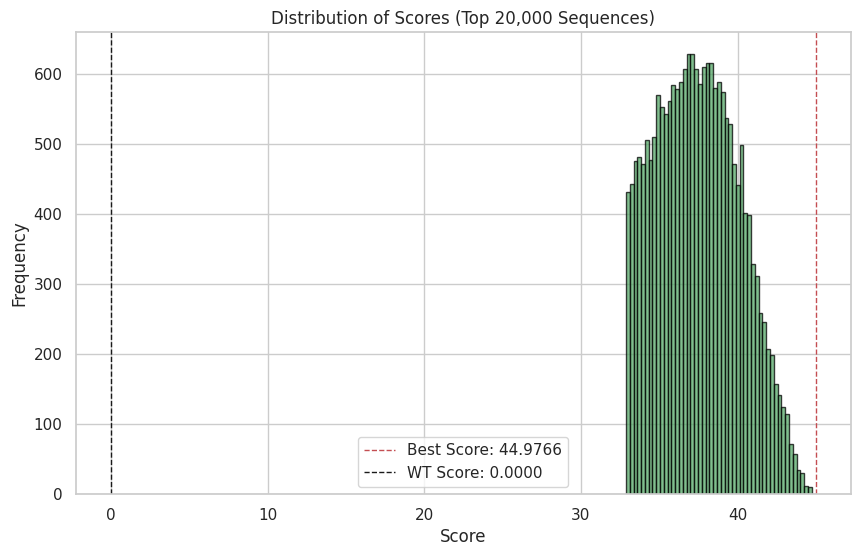

In [10]:

# Visualize scores of designed sequences

# Compute the percentiles
percentiles = np.percentile(df['ml_score'], [25, 50, 75, 90, 99])

# Find the best sequence and its score
best_score = df['ml_score'].max()
best_sequence = df.loc[df['ml_score'].idxmax(), 'sequences']

# Print the unique sequences found
print(f"There were {len(set(df['sequences']))} unique sequences found.")

# Print the best sequence and its score
print(f"Best Sequence:")
print(best_sequence)

print(f"Best Score: {best_score:.4f}")

# Print the percentiles
print(f"Percentiles:")
print(f"  25th Percentile: {percentiles[0]:.4f}")
print(f"  50th Percentile: {percentiles[1]:.4f}")
print(f"  75th Percentile: {percentiles[2]:.4f}")
print(f"  90th Percentile: {percentiles[3]:.4f}")
print(f"  99th Percentile: {percentiles[4]:.4f}")

# Plot the score distribution of the top 10,000 sequences
top_n = 20000
top_10000_df = df.nlargest(top_n, 'ml_score')

plt.figure(figsize=(10, 6))
plt.hist(top_10000_df['ml_score'], bins=50, alpha=0.75, color='g', edgecolor='black')
plt.axvline(best_score, color='r', linestyle='dashed', linewidth=1, label=f'Best Score: {best_score:.4f}')
plt.axvline(optimizer.wt_score, color='k', linestyle='dashed', linewidth=1, label=f'WT Score: {float(optimizer.wt_score):.4f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scores (Top {top_n:,} Sequences)')
plt.legend()
plt.grid(True)
plt.savefig(f'Distribution of Scores (Top {top_n:,} Sequences)', bbox_inches='tight', dpi=200)
plt.show()

## Using Seq2Fitness model for num_mutations=5

In [11]:
# Initialize optimizer

model_path = '../trained_models/Seq2Fitness_AAmylsase_DEMLPaper__modelrank_1_epoch_45_val_loss_0.5990.pt'

new_task_weights = {'fitness_dp3_activity': 2.0, 'fitness_stain_removal': 1.0}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': 3.5,
    'reversal_threshold': 0.0,
    'seqs_per_iter': 520, # typically 1000
    'num_iter': 200, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, 
    'cooling_rate': 0.93, 
    'num_mutations': 5,
    'sample_variety_of_mutation_numbers': False,
    'sites_to_ignore': [1] # High tendency to mutate to Met, so avoid
}


optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path,
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat=False)
print(f"phase transition threshold is {optimizer.score_threshold}")

Our main device will be cuda:0
Total number of trainable parameters in the model: 125470
Number of trainable parameters in the model excluding ESM: 125470
Total number of parameters in the model: 651168724
The reference sequence is LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTPIKNWSDRWDVTQNSLSGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSVSRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYAVDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPD.
We'll use 2 GPUs through DataParallel.
Our main device is still cuda:0
The reference sequence has score 0.8.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 8056 single mutants.
Finished sequence 0 of 8056.
Finished sequence 500 of 8056.
Finished sequenc

In [12]:
# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 7.03e+03 effective entries: 379 sites, 19.4 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 520 sequences. Finished iter 0 with mean ml score of -0.569, and std. dev. 0.342.
Starting iter 1: processing 520 sequences, using T = 1.4.
Joint probability has 6.96e+03 effective entries: 377 sites, 19.4 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 1040 sequences. Finished iter 1 with mean ml score of -0.565, and std. dev. 0.33.
Starting iter 2: processing 520 sequences, using T = 1.3.
Joint probability has 6.91e+03 effective entries: 375 sites, 19.4 amino acids.
>> 520 out of 520 sequences this iteration are new and will be scored.
We have explored 1560 sequences. Finished iter 2 with mean ml score of -0.557, and std. dev. 0.357.
Starting iter 3: processing 520 sequences, using T = 1.2.
Joint probability ha

/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py

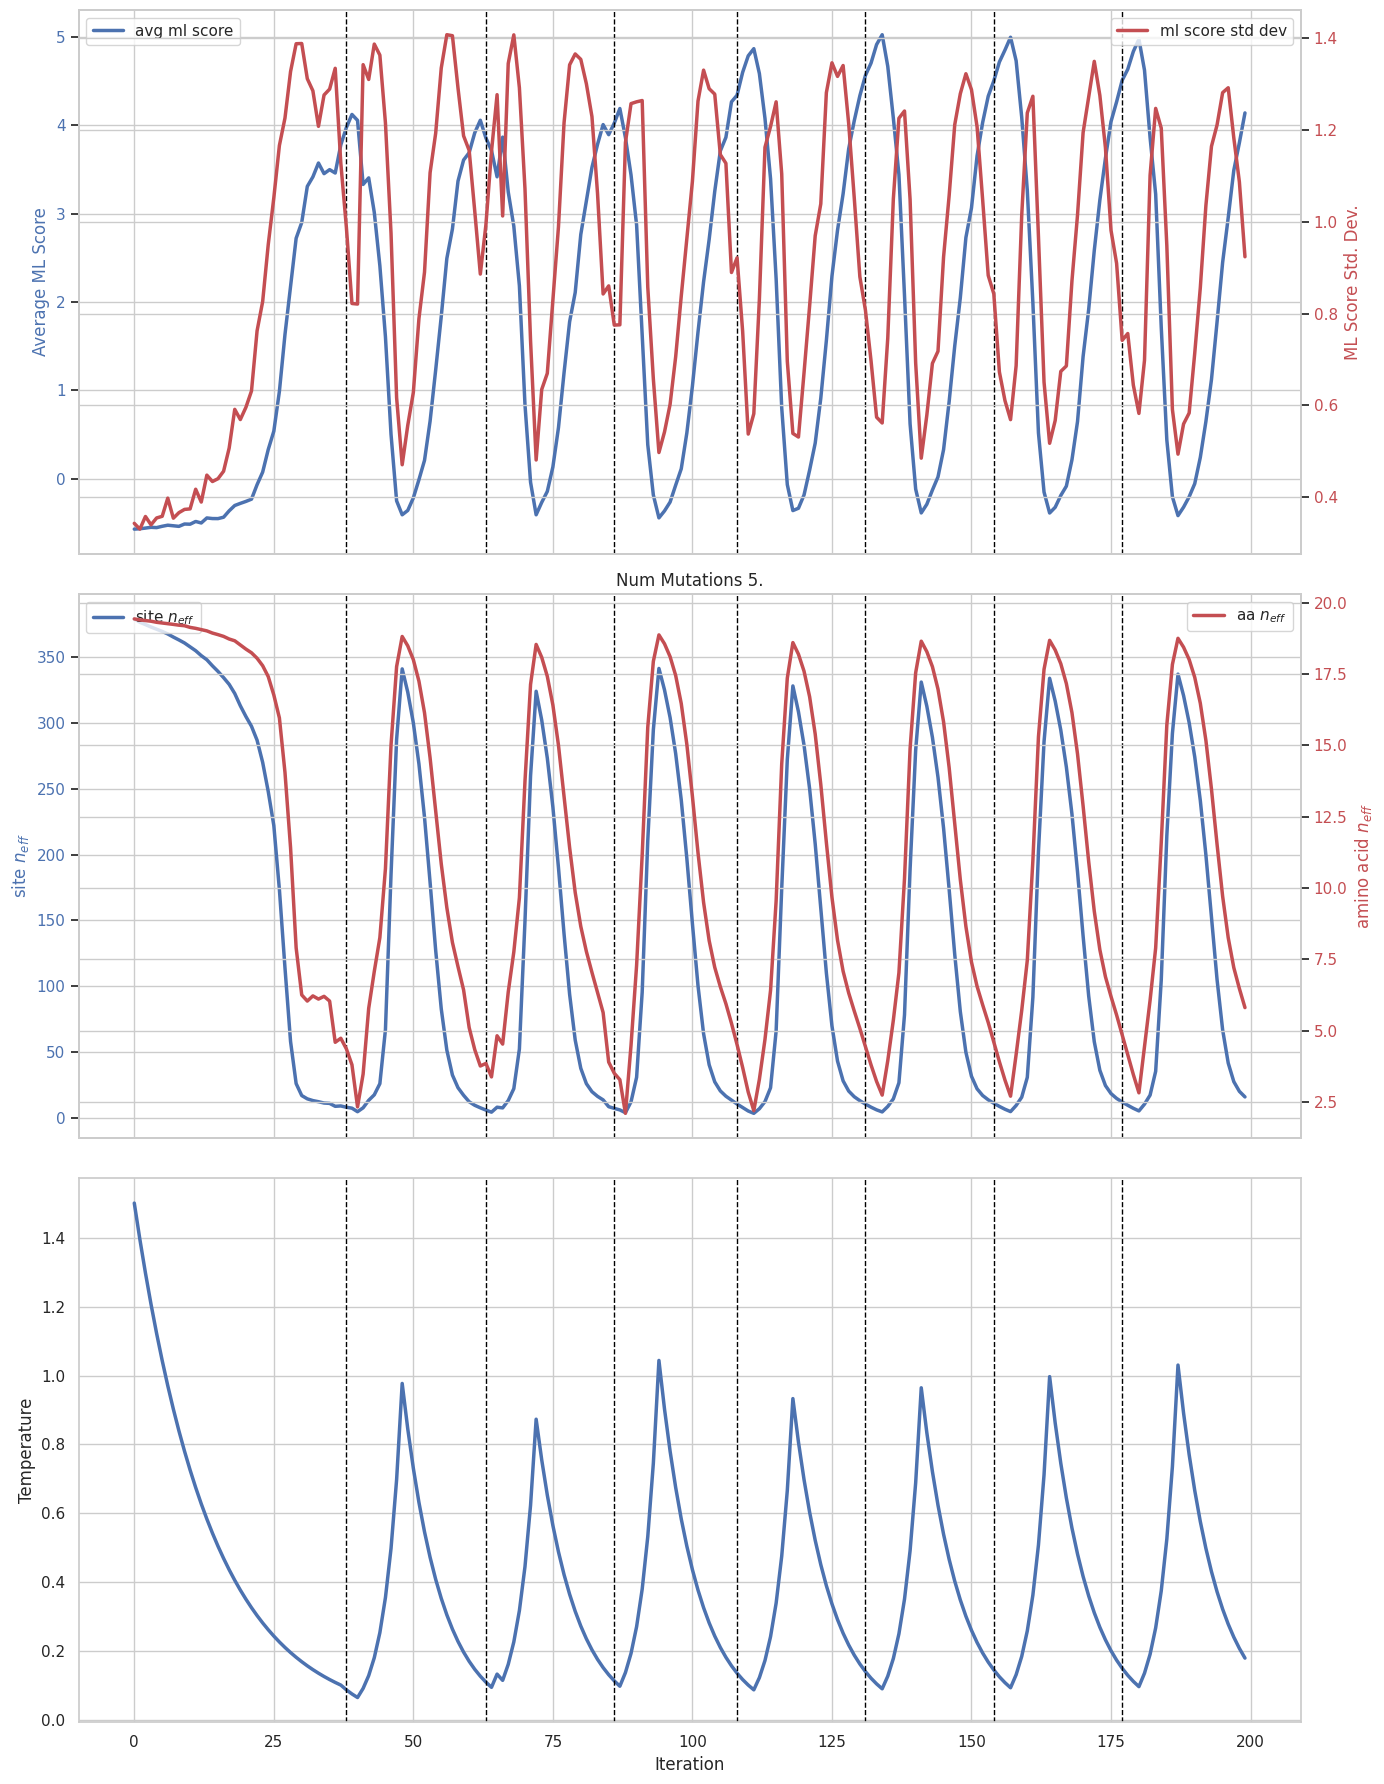

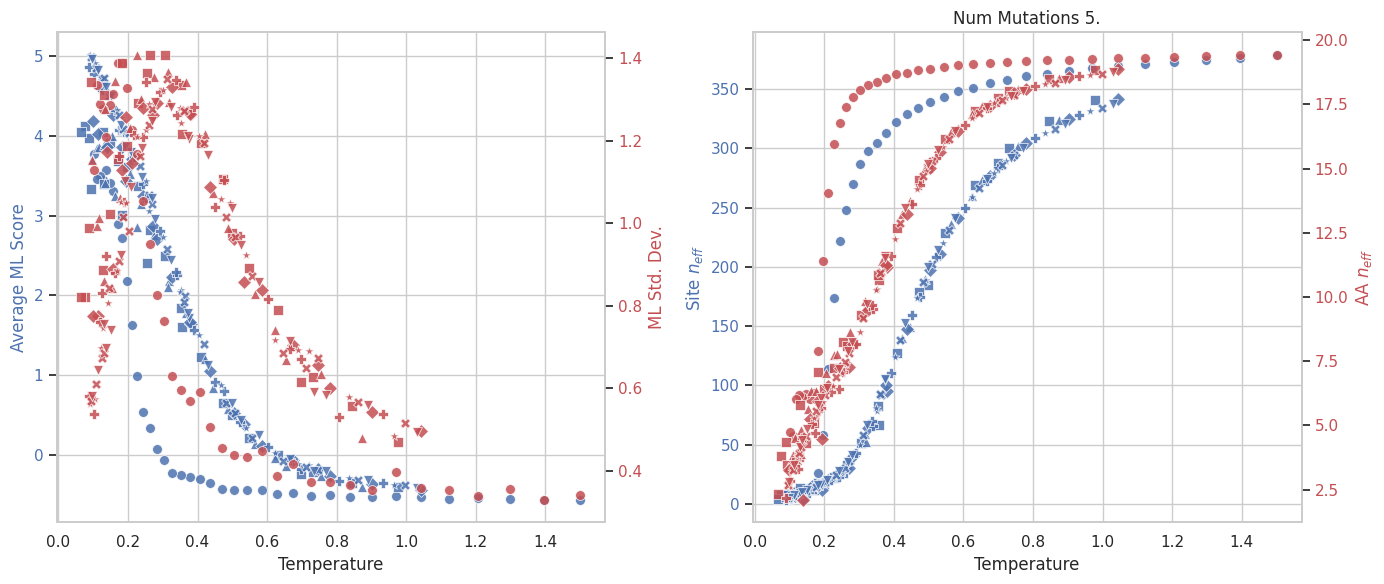

37
37


/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/projects/proteinml/.links/miniconda3/envs/badass/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


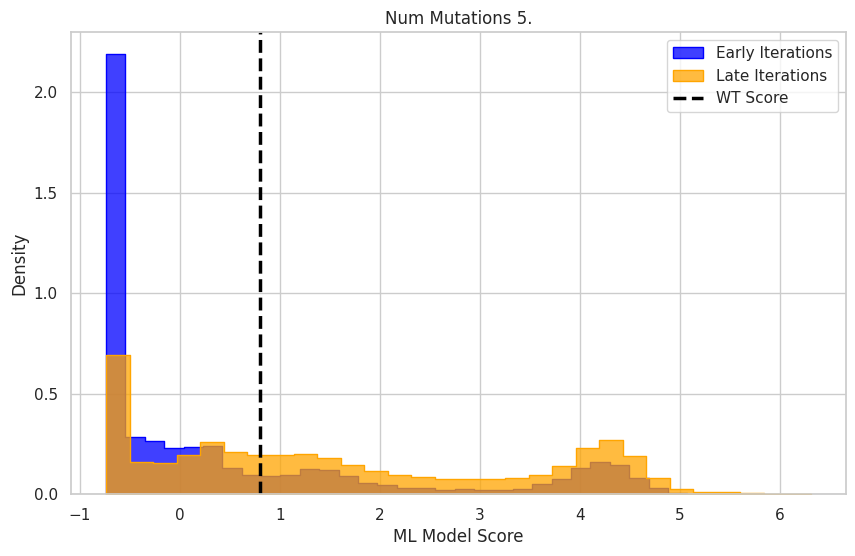

In [13]:
# Visualize optimizer history
optimizer.plot_scores()

In [14]:
# Save optimizer results
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
seed = optimizer_params['seed']
fn = f"protein_optimizer_results_num_mutations_{n_mut}_nsteps_{n_steps}_seed_{seed}_n_seqs_to_keep_{len(df)}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=None)

In [15]:
# Print duration
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")
torch.cuda.empty_cache()
gc.collect()

Elapsed time: 829.12 seconds


23652

There were 85114 unique sequences found.
Best Sequence:
T2L-P4Q-A108W-T125L-N359Q
Best Score: 6.3089
Percentiles:
  25th Percentile: -0.3674
  50th Percentile: 0.8989
  75th Percentile: 3.1068
  90th Percentile: 4.2945
  99th Percentile: 4.9432


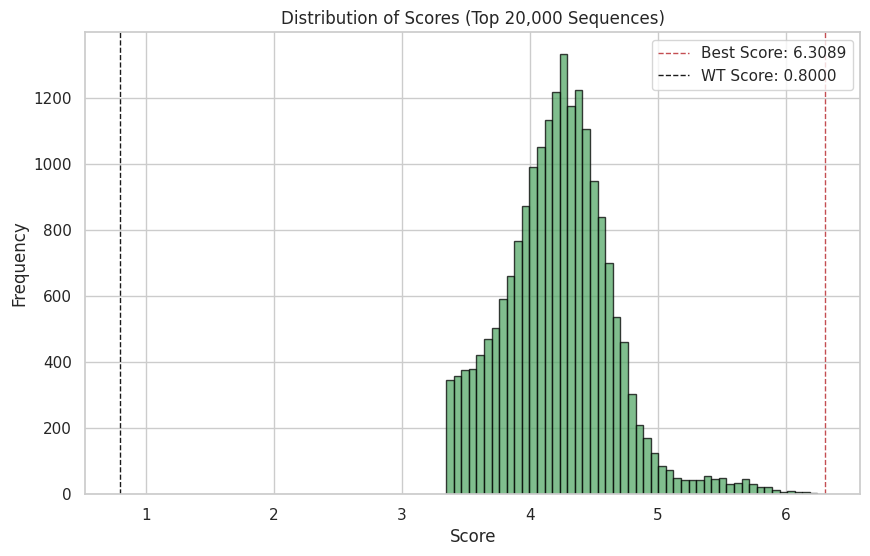

In [16]:
# Assuming df is already loaded with the given structure

# Compute the percentiles
percentiles = np.percentile(df['ml_score'], [25, 50, 75, 90, 99])

# Find the best sequence and its score
best_score = df['ml_score'].max()
best_sequence = df.loc[df['ml_score'].idxmax(), 'sequences']

# Print the unique sequences found
print(f"There were {len(set(df['sequences']))} unique sequences found.")

# Print the best sequence and its score
print(f"Best Sequence:")
print(best_sequence)

print(f"Best Score: {best_score:.4f}")

# Print the percentiles
print(f"Percentiles:")
print(f"  25th Percentile: {percentiles[0]:.4f}")
print(f"  50th Percentile: {percentiles[1]:.4f}")
print(f"  75th Percentile: {percentiles[2]:.4f}")
print(f"  90th Percentile: {percentiles[3]:.4f}")
print(f"  99th Percentile: {percentiles[4]:.4f}")

# Plot the score distribution of the top 10,000 sequences
top_n = 20000
top_10000_df = df.nlargest(top_n, 'ml_score')

plt.figure(figsize=(10, 6))
plt.hist(top_10000_df['ml_score'], bins=50, alpha=0.75, color='g', edgecolor='black')
plt.axvline(best_score, color='r', linestyle='dashed', linewidth=1, label=f'Best Score: {best_score:.4f}')
plt.axvline(optimizer.wt_score, color='k', linestyle='dashed', linewidth=1, label=f'WT Score: {float(optimizer.wt_score):.4f}')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(f'Distribution of Scores (Top {top_n:,} Sequences)')
plt.legend()
plt.grid(True)
plt.savefig(f'Distribution of Scores (Top {top_n:,} Sequences)', bbox_inches='tight', dpi=200)
plt.show()


## Using Seq2Fitness model for num_mutations from 2 to 6

Run the code as with num_mutations=5, but specify `sample_variety_of_mutation_numbers = True` in `optimizer_params`

In [ ]:
# Initialize optimizer

model_path = '../trained_models/Seq2Fitness_AAmylsase_DEMLPaper__modelrank_1_epoch_45_val_loss_0.5990.pt'

new_task_weights = {'fitness_dp3_activity': 2.0, 'fitness_stain_removal': 1.0}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': 3.5,
    'reversal_threshold': 0.0,
    'seqs_per_iter': 520, # typically 1000
    'num_iter': 20, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, 
    'cooling_rate': 0.93, 
    'sites_to_ignore': [1], # High tendency to mutate to Met, so avoid
    'sample_variety_of_mutation_numbers': True, # Set to True to sample mixed number of mutations
    'num_mutations': 6, # Maximum number of mutations to sample
    'num_sequences_proportions': [0, 1, 1, 1, 1, 1] # Ratio of sequences to sample with 1, 2, 3, 4, 5, and 6 mutations, respectively.
}



optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path,
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat=False)
print(f"phase transition threshold is {optimizer.score_threshold}")